## Histograms of Numeric Features

These histograms show the distribution of each numeric feature in the synthetic dataset. This helps to quickly spot outliers, skewness, and the general shape of the data for each variable.


,duration,priority,subtasks,deadline_days,created_to_deadline,user_past_completion,task_type,description_length,comments_count,assigned_team_size,user_availability,no_curr_assigned_tasks,tasks_completed,avg_completion_time,task_type_numeric,completed_on_time
0,6,2,3,9.0,14.0,0.93,feature,149,6,1,33,3,39,1.03,1,1
1,10,2,4,18.0,18.0,0.91,feature,141,7,1,123,1,59,0.89,1,1
2,7,3,3,9.0,23.0,0.90,bug,152,3,2,33,4,36,1.17,0,0
3,9,2,1,9.0,17.0,0.83,feature,128,5,1,60,0,36,0.86,1,1
4,4,3,2,5.0,7.0,0.99,bug,170,6,3,21,2,27,1.04,0,1


Number of observations: 10000


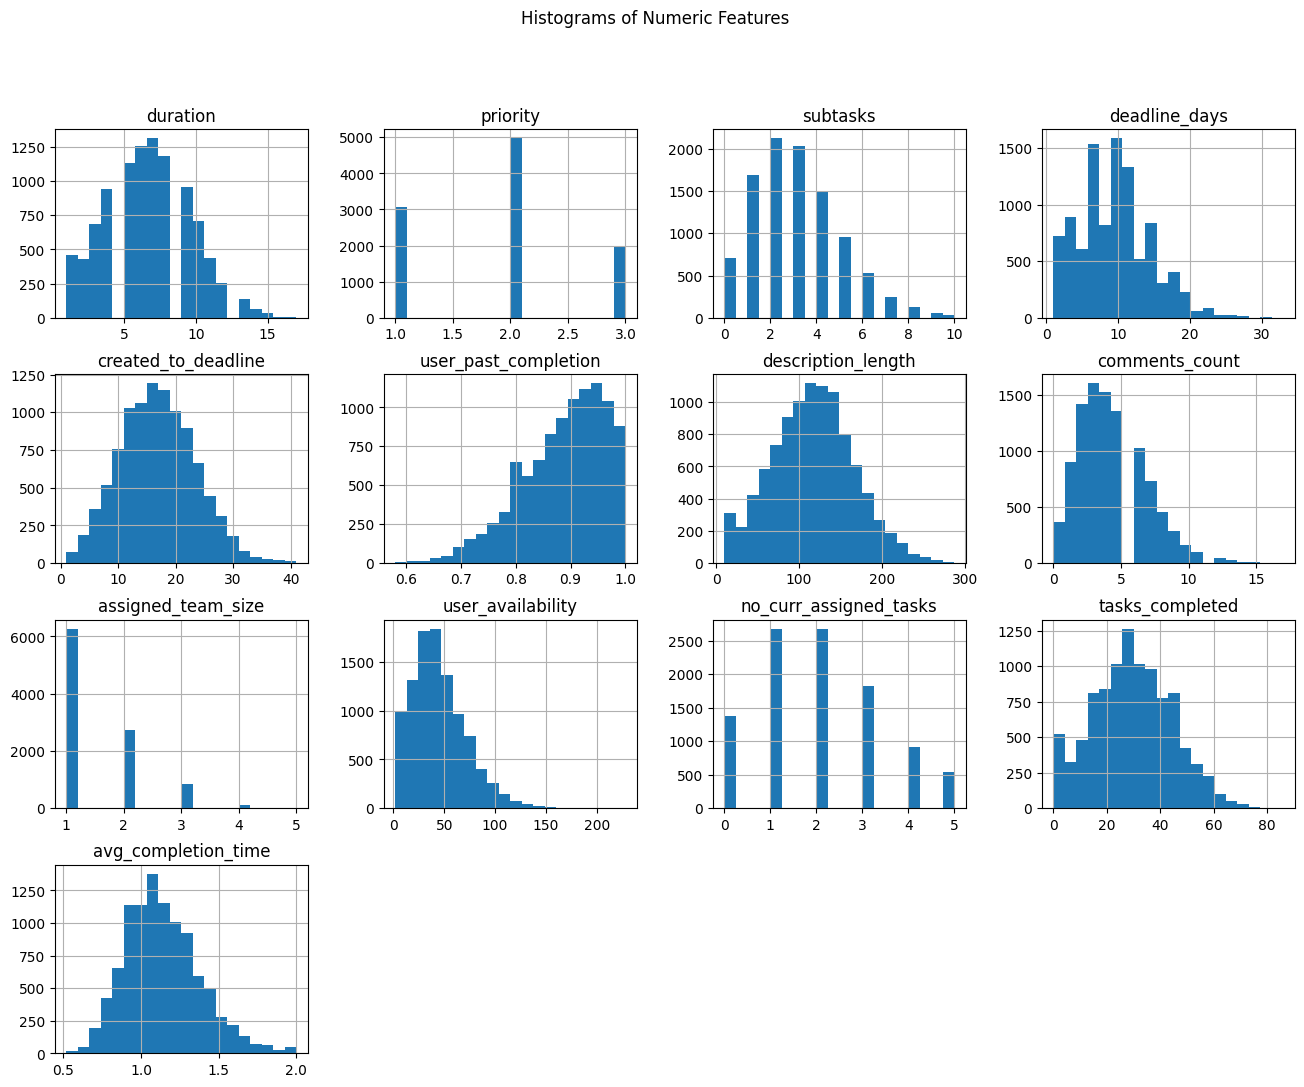

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("synth_data_set_v2.csv")

numeric_cols = [
    'duration', 'priority', 'subtasks', 'deadline_days', 'created_to_deadline',
    'user_past_completion', 'description_length', 'comments_count',
    'assigned_team_size', 'user_availability', 'no_curr_assigned_tasks',
    'tasks_completed', 'avg_completion_time'
]

# Display the first few rows
display(df.head())

# Display the number of observations
print(f"Number of observations: {len(df)}")

# Plot histograms
df[numeric_cols].hist(bins=20, figsize=(16, 12))
plt.suptitle("Histograms of Numeric Features")
plt.show()

## Task Type Distribution

This bar plot shows the frequency of each task type in the dataset. It helps to understand how balanced or imbalanced the categorical variable `task_type` is.


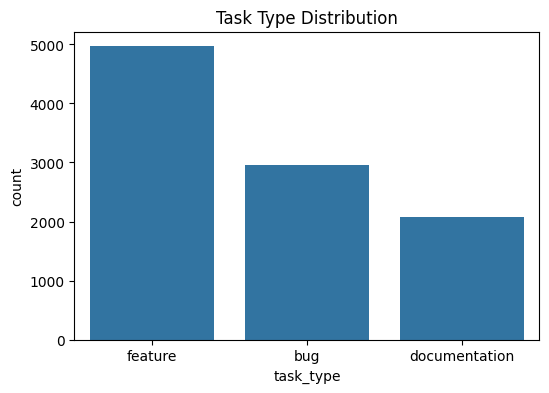

In [2]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='task_type', data=df)
plt.title("Task Type Distribution")
plt.show()

## Correlation Heatmap

The heatmap below visualizes the correlation coefficients between numeric features. Strong positive or negative correlations can indicate redundancy or interesting relationships in the data.


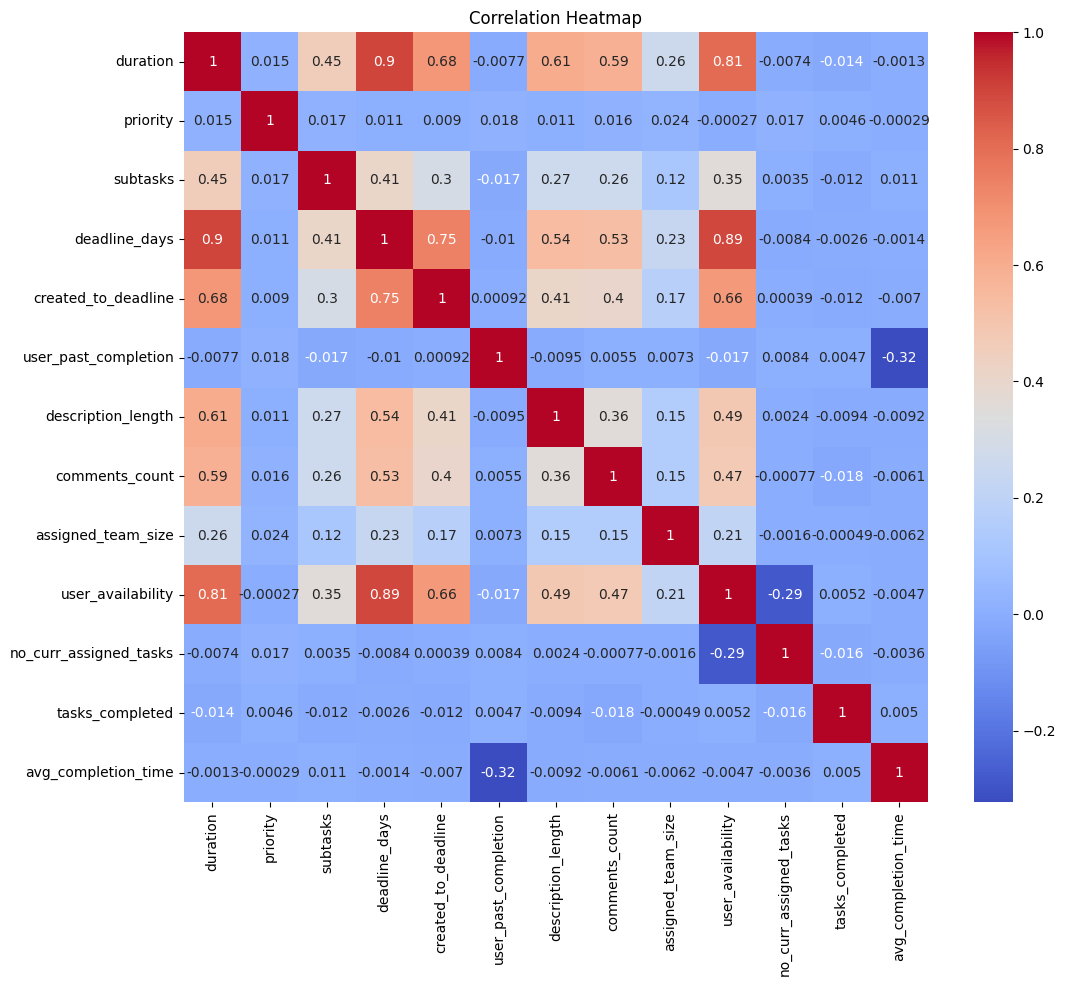

In [3]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Duration by Task Type

This boxplot shows the distribution of task durations for each task type. It helps to compare the spread and central tendency of duration across different categories.


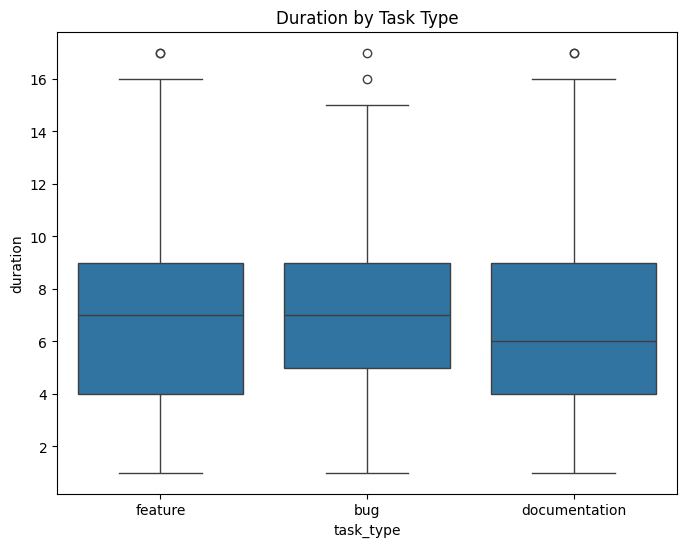

In [4]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='task_type', y='duration', data=df)
plt.title("Duration by Task Type")
plt.show()

## Pairplot of Selected Features

The pairplot below shows pairwise relationships between selected features, colored by `task_type`. This is useful for visualizing potential class separation and feature interactions.


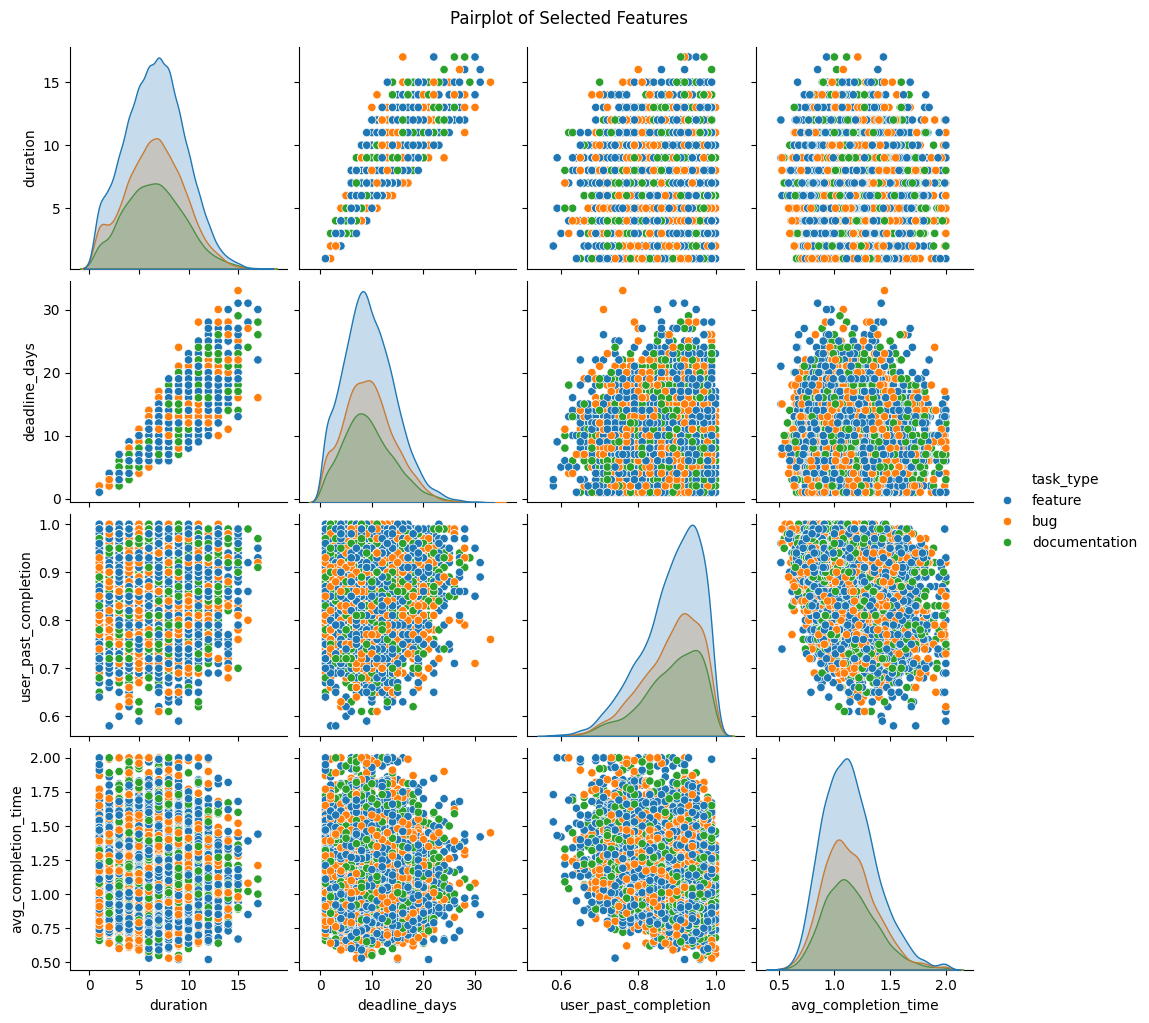

In [5]:
sns.pairplot(df, vars=['duration', 'deadline_days', 'user_past_completion', 'avg_completion_time'], 
             hue='task_type')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

## Class Balance: Completed on Time

This pie chart shows the proportion of tasks that were completed on time versus those that were not. It helps to quickly assess class imbalance in the target variable.


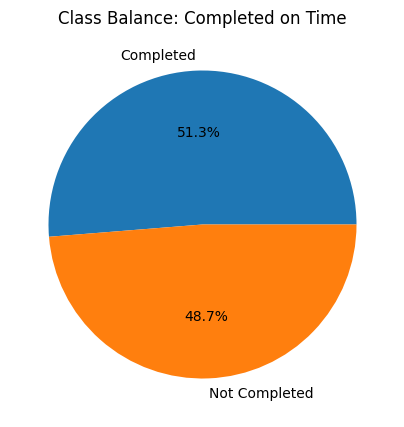

In [6]:
plt.figure(figsize=(5, 5))
df['completed_on_time'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Completed', 'Not Completed'])
plt.title("Class Balance: Completed on Time")
plt.ylabel("")
plt.show()

## PCA of Feature Space (Colored by Completion)

This scatterplot shows the first two principal components of the numeric features, colored by whether the task was completed on time. It provides a 2D visualization of the high-dimensional feature space.


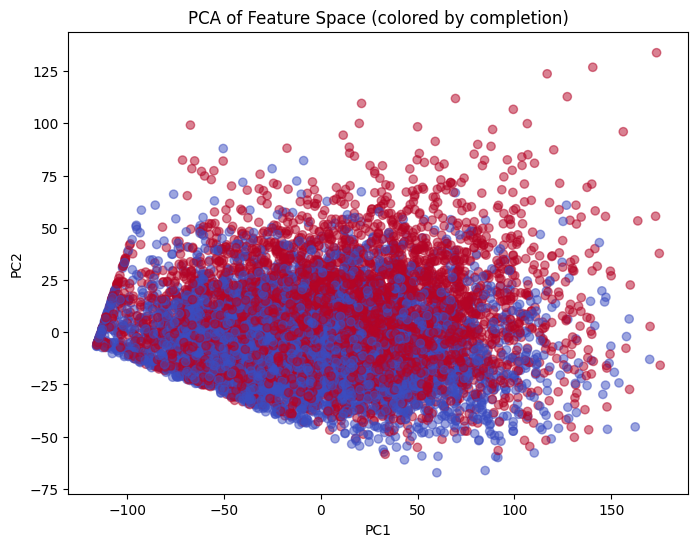

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df[numeric_cols])
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['completed_on_time'], cmap='coolwarm', alpha=0.5)
plt.title("PCA of Feature Space (colored by completion)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Model Explanation: SHAP and LIME

This notebook demonstrates how to use SHAP and LIME to explain a single prediction from our neural network model for task completion.


In [ ]:
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Load model and preprocessor
MODEL_PATH = "../app/models/trained_models/task_completion_prediction_model_nn.keras"
PREPROCESSOR_PATH = "../app/models/trained_models/preprocessor_nn.pkl"

model = load_model(MODEL_PATH)
preprocessor = joblib.load(PREPROCESSOR_PATH)

# Define the feature order (must match training)
categorical_features = ['task_type']
numerical_features = [
    'duration', 'priority', 'subtasks', 'deadline_days', 'created_to_deadline',
    'user_past_completion', 'description_length', 'comments_count',
    'assigned_team_size', 'user_availability', 'no_curr_assigned_tasks',
    'tasks_completed', 'avg_completion_time'
]

# Load your training data (or a sample)
X_train = pd.read_csv("synth_data_set_v2.csv")[numerical_features + categorical_features]
preprocessor.fit(X_train)

# Get feature names after preprocessing
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_features, cat_features])

# Example input (replace with your actual task)
input_dict = {
    "task_type": "feature",
    "priority": 3,
    "duration": 3,
    "subtasks": 0,
    "deadline_days": 30,
    "created_to_deadline": 31,
    "user_past_completion": 1,
    "description_length": 120,
    "comments_count": 5,
    "assigned_team_size": 5,
    "user_availability": 60,
    "no_curr_assigned_tasks": 1,
    "tasks_completed": 40,
    "avg_completion_time": 0.16
}
input_df = pd.DataFrame([input_dict])

# Preprocess input
X_input = preprocessor.transform(input_df)



## SHAP Analysis

SHAP (SHapley Additive exPlanations) shows how each feature contributed to the model's prediction for this specific task.


In [11]:
import shap
import matplotlib.pyplot as plt

# Use a sample of your processed training data as background
background = preprocessor.transform(X_train.sample(100, random_state=42))

def predict_proba(X):
    proba = model.predict(X)
    return np.hstack([1 - proba, proba])

explainer = shap.KernelExplainer(predict_proba, background)
shap_values = explainer.shap_values(X_input, nsamples=100)

# Debug prints
print("all_feature_names:", all_feature_names.shape)
print("X_input shape:", X_input.shape)
print("X_input[0] shape:", X_input[0].shape)
print("shap_values type:", type(shap_values))
print("explainer.expected_value:", explainer.expected_value)
print("explainer.expected_value type:", type(explainer.expected_value))

if isinstance(shap_values, list):
    print("shap_values is a list with length:", len(shap_values))
    for i, sv in enumerate(shap_values):
        print(f"shap_values[{i}] shape:", sv.shape)
else:
    print("shap_values shape:", shap_values.shape)

# Now we know the exact structure: shap_values.shape = (1, 17, 2)
# This means: [samples, features, classes]

# For binary classification, we want to show the positive class (index 1)
# Extract SHAP values for the positive class (completed tasks)
shap_values_positive_class = shap_values[0, :, 1]  # First sample, all features, positive class
expected_value_positive_class = explainer.expected_value[1]  # Expected value for positive class

print(f"SHAP values for positive class shape: {shap_values_positive_class.shape}")
print(f"Expected value for positive class: {expected_value_positive_class}")
print(f"Feature names count: {len(all_feature_names)}")

# Now plot using the old API (which should work with correct dimensions)
shap_explanation = list(zip(all_feature_names, shap_values_positive_class))

# Sort by absolute impact (optional, for top features)
shap_explanation_sorted = sorted(shap_explanation, key=lambda x: abs(x[1]), reverse=True)

# Print top N features
N = 10
print("SHAP Explanation (Top Features):")
for feature, value in shap_explanation_sorted[:N]:
    print(f"{feature}: {value:.4f}")



shap.initjs()
shap.force_plot(
    expected_value_positive_class,
    shap_values_positive_class, 
    X_input[0],
    feature_names=all_feature_names
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
all_feature_names: (16,)
X_input shape: (1, 16)
X_input[0] shape: (16,)
shap_values type: <class 'numpy.ndarray'>
explainer.expected_value: [0.46091343 0.53908657]
explainer.expected_value type: <class 'numpy.ndarray'>
shap_values shape: (1, 16, 2)
SHAP values for positive class shape: (16,)
Expected value for positive class: 0.5390865697602202
Feature names count: 16
SHAP Explanation (Top Features):
avg_completion_time: 0.1321
deadline_days: 0.1109
user_past_completion: 0.0541
assigned_team_size: 0.0379
description_length: 0.0314
no_curr_assigned_tasks: 0.0257
user_availability: 0.0212
tasks_completed: 0.0206
task_type_feature: 0.0154
duration: 0.0117


## LIME Analysis

LIME (Local Interpretable Model-agnostic Explanations) fits a simple model around the prediction to show which features were most important for this specific input.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
LIME Explanation (Top Features):
user_past_completion > 0.59: 0.3057
avg_completion_time <= -0.71: 0.2744
deadline_days > 0.65: 0.1660
duration <= -0.67: 0.1388
subtasks <= -0.70: 0.1380
tasks_completed > 0.62: 0.1311
priority > 0.74: 0.0665
-0.11 < user_availability <= 0.70: 0.0549
task_type_feature > 0.55: 0.0494
created_to_deadline > 0.80: 0.0386


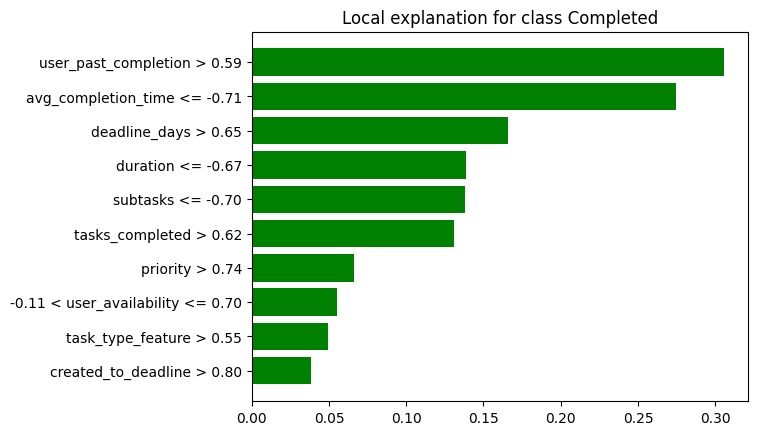

In [13]:
from lime.lime_tabular import LimeTabularExplainer

# For LIME, use a sample of your training data as background
# If you have your processed training data, use it here
background = np.random.randn(100, X_input.shape[1])

explainer = LimeTabularExplainer(
    training_data=background,
    feature_names=all_feature_names,
    class_names=['Not Completed', 'Completed'],
    mode='classification'
)

# LIME expects a function that returns probabilities
def predict_fn(x):
    return np.hstack([1 - model.predict(x), model.predict(x)])

exp = explainer.explain_instance(
    X_input[0],
    predict_fn,
    num_features=10
)

lime_explanation = exp.as_list()

# Print in a readable format
print("LIME Explanation (Top Features):")
for feature, weight in lime_explanation:
    print(f"{feature}: {weight:.4f}")


# Show explanation in notebook
fig = exp.as_pyplot_figure()
plt.show()
